In [1]:
import numpy as np
import torch
import os
import pandas as pd
import itertools as it
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# !cp /content/drive/MyDrive/SCR_Proj/transformer_HPO/utils.py .
import sys
from pathlib import Path
sys.path.append(str(Path("../../src").resolve()))
from utils import *

# !pip install optuna
# import optuna

In [3]:
# !pip install positional-encodings[pytorch]
from positional_encodings.torch_encodings import PositionalEncoding1D, Summer

In [4]:
def read_range(f_path, segment_index, device):
    """
    Reads a specific segment of data from a CSV file, reshapes it, and transfers it to the specified device.

    Args:
    f_path (str): The path to the CSV file.
    segment_index (int): The index of the segment to extract from the CSV.
    device (torch.device): The device to transfer the data to (CPU or GPU).

    Returns:
    torch.Tensor: The extracted and reshaped data transferred to the specified device.
    """
    sub_dif = pd.read_csv(f_path, header=None).iloc[:, segment_index]
    sub_dif = sub_dif.reset_index(inplace=False, drop=True)
    sub_dif = sub_dif.to_numpy().reshape(-1, len(segment_index)*3)
    sub_dif = torch.from_numpy(sub_dif).to(device)
    return sub_dif

def nRMSE_compute(L_tar_data, L_pred_data, my_range_data, Test_List_data, input_frames_data, segment_len_data, device):
    """
    Compute the normalized Root Mean Squared Error (nRMSE) between the target and predicted data.

    Args:
    L_tar_data (torch.Tensor): The target values (actual data).
    L_pred_data (torch.Tensor): The predicted values.
    my_range_data (torch.Tensor): The range data for normalization.
    Test_List_data (list): List of test data for determining the number of samples.
    input_frames_data (int): The number of input frames used for the prediction.
    segment_len_data (int): The length of each segment in the data.
    device (torch.device): The device on which the tensors are located (CPU or GPU).

    Returns:
    torch.Tensor: The computed normalized RMSE value.
    """
    
    # Compute squared error between target and predicted values, normalized by range data
    normalized_error = (L_tar_data.to(device) - L_pred_data.to(device)) / my_range_data.to(device)
    squared_error = torch.sum(torch.sum(normalized_error ** 2))
    
    # Normalize the total squared error by the number of samples and compute the square root
    num_samples = len(Test_List_data) * (101 - input_frames_data) * segment_len_data
    nrmse = torch.sqrt(squared_error / num_samples)
    
    return nrmse


def RMSE_compute(L_tar_data, L_pred_data, Test_List_data, input_frames_data, segment_len_data, device):
    """
    Compute the Root Mean Squared Error (RMSE) between the target and predicted data.

    Args:
    L_tar_data (torch.Tensor): The target values (actual data).
    L_pred_data (torch.Tensor): The predicted values.
    Test_List_data (list): List of test data for determining the number of samples.
    input_frames_data (int): The number of input frames used for the prediction.
    segment_len_data (int): The length of each segment in the data.
    device (torch.device): The device on which the tensors are located (CPU or GPU).

    Returns:
    torch.Tensor: The computed RMSE value.
    """
    # Calculate squared error between target and predicted data, then sum it up
    squared_error = (L_tar_data.to(device) - L_pred_data.to(device))**2
    tot_loss = torch.sum(torch.sum(squared_error))
    
    # Normalize the total squared error by the number of samples and compute the square root
    num_samples = len(Test_List_data) * (101 - input_frames_data) * segment_len_data
    tot_loss = torch.sqrt(tot_loss / num_samples)

    return tot_loss


def r2_compute(L_tar_data, L_pred_data):
    """
    Compute the R² (coefficient of determination) score between the true and predicted values,
    after scaling both using the StandardScaler.

    Args:
    L_tar (numpy.ndarray or torch.Tensor): The true values.
    L_pred (numpy.ndarray or torch.Tensor): The predicted values.

    Returns:
    float: The R² score, a measure of the goodness of fit.
    """
    # Ensure that input data is in the correct shape (2D array) for scaling
    scaler = StandardScaler()

    # Reshape and scale the true and predicted values
    scaled_y_true = scaler.fit_transform(L_tar_data.reshape(-1, 1))
    scaled_y_pred = scaler.transform(L_pred_data.reshape(-1, 1))

    # Compute the R² score
    r2 = r2_score(scaled_y_true, scaled_y_pred)

    return r2

In [5]:
input_frames, predicted_frames, my_stride = 25, 1, 1
num_of_sub = 20
val_sub = [2, 8, 9, 14]
test_sub = [13, 15]
test_sub_1 = [13]
test_sub_2 = [15]
segment_ind = [29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]
body_segment_name = 'Leg'

In [6]:
# path to proceesed folder
proceesed_path = 'C:/Niloofar/SCR/posture-prediction-models-main/data/data_20_4_2025/Normalized'
val_pathes = []
for i in val_sub:
  val_pathes.append(os.path.join(proceesed_path, f's{i}_fn'))

test_pathes = []
for i in test_sub:
  test_pathes.append(os.path.join(proceesed_path, f's{i}_fn'))

path_to_subject_mean = os.path.join('C:/Niloofar/SCR/posture-prediction-models-main/data/mean-std_20_4_2025', 'mean.csv')
path_to_subject_std = os.path.join('C:/Niloofar/SCR/posture-prediction-models-main/data/mean-std_20_4_2025', 'std.csv')
path_to_subject_range = os.path.join('C:/Niloofar/SCR/posture-prediction-models-main/data/mean-std_20_4_2025', 'dif.csv')

path_to_folder = 'C:/Niloofar/SCR/posture-prediction-models-main/models/transformer_leg'
path_to_outputs = 'C:/Niloofar/SCR/posture-prediction-models-main/outputs/transformer_leg'

In [7]:
val_pathes, test_pathes

(['C:/Niloofar/SCR/posture-prediction-models-main/data/data_20_4_2025/Normalized\\s2_fn',
  'C:/Niloofar/SCR/posture-prediction-models-main/data/data_20_4_2025/Normalized\\s8_fn',
  'C:/Niloofar/SCR/posture-prediction-models-main/data/data_20_4_2025/Normalized\\s9_fn',
  'C:/Niloofar/SCR/posture-prediction-models-main/data/data_20_4_2025/Normalized\\s14_fn'],
 ['C:/Niloofar/SCR/posture-prediction-models-main/data/data_20_4_2025/Normalized\\s13_fn',
  'C:/Niloofar/SCR/posture-prediction-models-main/data/data_20_4_2025/Normalized\\s15_fn'])

In [8]:
Val_List = []
Test_List = []
Test_1_List = []
Test_2_List = []

for val_path in val_pathes:
  test_ls, segment_len, _ = read_test(val_path, body_segment_name)
  Val_List.extend(test_ls)

# print(len(Val_List), Val_List[0].shape)

for test_path in test_pathes:
  test_ls, segment_len, _ = read_test(test_path, body_segment_name)
  Test_List.extend(test_ls)

test_1_ls, _, _ = read_test(test_pathes[0], body_segment_name)
Test_1_List.extend(test_1_ls)

test_2_ls, _, _ = read_test(test_pathes[1], body_segment_name)
Test_2_List.extend(test_2_ls)

print(len(Test_List), Test_List[0].shape)

405 (101, 43)


In [9]:
train_data = []
val_data = []
test_data = []

for i in range(1, num_of_sub+1):
  if i in val_sub:
    dd, path2files = windower(proceesed_path, i, input_frames, predicted_frames, my_stride, body_segment_name)
    val_data.extend(dd)
  elif i in test_sub:
    dd, path2files = windower(proceesed_path, i, input_frames, predicted_frames, my_stride, body_segment_name)
    test_data.extend(dd)
  else:
    dd, _ = windower(proceesed_path, i, input_frames, predicted_frames, my_stride, body_segment_name)
    train_data.extend(dd)




In [10]:
len(train_data), len(val_data), len(test_data)

(199576, 57912, 30780)

## Data Loader

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cpu


In [12]:
my_mean = pd.read_csv(path_to_subject_mean, header=None).iloc[:, segment_ind]
my_std = pd.read_csv(path_to_subject_std, header=None).iloc[:, segment_ind]
my_range = read_range(path_to_subject_range, segment_ind, device)

denormalize_transform = Denormalizer(my_mean, my_std, predicted_frames, device)
tot_denormalize_transform = Denormalizer(my_mean, my_std, 101, device)

train_ds = MyDataset(train_data)
val_ds = MyDataset(val_data)
test_ds = MyDataset(test_data)

In [13]:
batch_size = 512
train_dl = DataLoader(train_ds, batch_size= batch_size,
                      shuffle=True)
val_dl = DataLoader(val_ds, batch_size= batch_size,
                      shuffle=True)
test_dl = DataLoader(test_ds, batch_size= batch_size,
                      shuffle=True)

## Model Implementation

In [14]:
class TransformerBased(nn.Module):
  def __init__(self, in_ftrs, d_model=64, num_head=8, num_feed_forward=2048, drop_trans=0.2, enc_num_layers=1, dec_num_layers=1, drop_fc=0.01, out_neurons=100):
    super(TransformerBased, self).__init__()
    self.in_ftrs = in_ftrs
    self.d_model = d_model
    self.out_neurons = out_neurons

    self.dim_expander = nn.Linear(self.in_ftrs, self.d_model)

    self.p_enc = Summer(PositionalEncoding1D(self.d_model))

    self.encoder = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=d_model, nhead=num_head,
                                                    dim_feedforward=num_feed_forward,
                                                    dropout=drop_trans, batch_first=True),
                                          num_layers=enc_num_layers)


    self.decoder = nn.TransformerDecoder(nn.TransformerDecoderLayer(d_model=d_model, nhead=num_head,
                                                     dim_feedforward=num_feed_forward,
                                                     dropout=drop_trans, batch_first=True),
                          num_layers=dec_num_layers)

    self.fc = nn.Sequential(nn.Linear(self.d_model, self.out_neurons),
                            nn.ReLU(),
                            nn.Dropout(drop_fc),
                            nn.Linear(self.out_neurons, self.in_ftrs-7))

  def forward(self, src):
    tgt = src[:, -1, :].unsqueeze(1)
    src = self.dim_expander(src)
    tgt = self.dim_expander(tgt)
    src = self.p_enc(src)
    tgt = self.p_enc(tgt)
    encoded = self.encoder(src)
    out = self.decoder(tgt, encoded)
    out = self.fc(out)
    return out


In [15]:
model = TransformerBased(43, d_model=96, num_head=16, num_feed_forward=512, drop_trans=0.25, enc_num_layers=1, dec_num_layers=3, drop_fc=0, out_neurons=64)


model.to(device)

TransformerBased(
  (dim_expander): Linear(in_features=43, out_features=96, bias=True)
  (p_enc): Summer(
    (penc): PositionalEncoding1D()
  )
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=96, out_features=96, bias=True)
        )
        (linear1): Linear(in_features=96, out_features=512, bias=True)
        (dropout): Dropout(p=0.25, inplace=False)
        (linear2): Linear(in_features=512, out_features=96, bias=True)
        (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.25, inplace=False)
        (dropout2): Dropout(p=0.25, inplace=False)
      )
    )
  )
  (decoder): TransformerDecoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerDecoderLayer(
        (self_attn): MultiheadAttention(
          (out_pr

In [16]:
count_parameters(model)

671268

# HyperParameter Tuning

In [ ]:
def objective(trial):
    epochs = 15

    # Define hyperparameters
    d_model = trial.suggest_categorical("d_model", [64, 96, 128])
    num_head = trial.suggest_categorical("num_head", [8, 16, 32])
    num_feed_forward = trial.suggest_categorical("num_feed_forward", [256, 512, 1024, 2048])
    drop_trans = trial.suggest_categorical("drop_trans", [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5])
    enc_num_layers = trial.suggest_categorical("enc_num_layers", [1, 2, 3, 4])
    dec_num_layers = trial.suggest_categorical("dec_num_layers", [1, 2, 3, 4])
    out_neurons = trial.suggest_categorical("out_neurons", [64, 128, 256])
    drop_fc = trial.suggest_categorical("drop_fc", [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5])
    # l_r = trial.suggest_categorical("l_r", [0.05, 0.01, 0.001])


    # Create and train the model
    model = TransformerBased(43, d_model, num_head, num_feed_forward, drop_trans, enc_num_layers, dec_num_layers, drop_fc=drop_fc, out_neurons=out_neurons).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.98), eps=1e-09)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1,
                                                       patience=5, min_lr=1e-7, verbose=True)

    for step in range(epochs):
        train_loss = train_loop(model,
                        criterion,
                        optimizer,
                        train_dl,
                        test_dl,
                        epochs,
                        scheduler,
                        denormalize_transform,
                        device)

        val_loss = test_loop(model,
                              criterion,
                              optimizer,
                              train_dl,
                              val_dl,
                              epochs,
                              scheduler,
                              denormalize_transform,
                              device)

        scheduler.step(val_loss)
        trial.report(val_loss, step)

        if trial.should_prune():
            raise optuna.TrialPruned()


    return val_loss

study = optuna.create_study(direction="minimize",
                            pruner=optuna.pruners.MedianPruner(
        n_startup_trials=5, n_warmup_steps= 10, interval_steps=1
    ))
study.optimize(objective, n_trials=150)


[I 2023-08-04 17:03:28,144] A new study created in memory with name: no-name-81d562e2-43bd-45d9-840b-deb0479dc77c
[W 2023-08-04 17:03:33,879] Trial 0 failed with parameters: {'d_model': 96, 'num_head': 8, 'num_feed_forward': 512, 'drop_trans': 0.2, 'enc_num_layers': 3, 'dec_num_layers': 1, 'out_neurons': 256, 'drop_fc': 0.2} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-24-a3bf67f6e704>", line 24, in objective
    train_loss = train_loop(model,
  File "/content/utils.py", line 303, in train_loop
    loss.backward()
  File "/usr/local/lib/python3.10/dist-packages/torch/_tensor.py", line 487, in backward
    torch.autograd.backward(
  File "/usr/local/lib/python3.10/dist-packages/torch/autograd/__init__.py", line 200, in backward
    Variable._execution_engine.run_backward(  # Calls into the 

KeyboardInterrupt: ignored

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_slice(study)

In [ ]:
optuna.visualization.plot_contour(study)

In [ ]:
# Get parameters sorted by the importance values
importances = optuna.importance.get_param_importances(study)
params_sorted = list(importances.keys())

# Plot
fig = optuna.visualization.plot_rank(study, params=params_sorted[:4])
fig.show()

<ipython-input-27-835c4a61bc8d>:6: ExperimentalWarning:

plot_rank is experimental (supported from v3.2.0). The interface can change in the future.



In [ ]:
optuna.visualization.plot_intermediate_values(study)


In [ ]:
optuna.visualization.plot_param_importances(study)


In [ ]:
optuna.visualization.plot_param_importances(
    study, target=lambda t: t.duration.total_seconds(), target_name="duration"
)

In [ ]:
import joblib
joblib.dump(study, "study.pkl")

['study.pkl']

In [ ]:
# Load the study from the file
my_study = joblib.load("study.pkl")
print("Best trial until now:")
print(" Value: ", study.best_trial.value)
print(" Params: ")
for key, value in my_study.best_trial.params.items():
    print(f"    {key}: {value}")


Best trial until now:
 Value:  7.808763355505271
 Params: 
    d_model: 96
    num_head: 16
    num_feed_forward: 512
    drop_trans: 0.25
    enc_num_layers: 1
    dec_num_layers: 3
    out_neurons: 64


# Training *Model*

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=.001, betas=(0.9, 0.98), eps=1e-09)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1,
                                                       patience=5, min_lr=1e-7, verbose=True)


In [ ]:
epochs = 200
train_losses = np.zeros(epochs)
val_losses = np.zeros(epochs)
test_losses = np.zeros(epochs)
DTWs = np.zeros(epochs)
best_val_loss = float('inf')
best_DTW = float('inf')
for it in range(epochs):
  train_losses[it] = train_loop(model,
                                criterion,
                                optimizer,
                                train_dl,
                                val_dl,
                                epochs,
                                scheduler,
                                denormalize_transform,
                                device)

  val_losses[it] = test_loop(model,
                              criterion,
                              optimizer,
                              train_dl,
                              val_dl,
                              epochs,
                              scheduler,
                              denormalize_transform,
                              device)
  test_losses[it] = test_loop(model,
                              criterion,
                              optimizer,
                              train_dl,
                              test_dl,
                              epochs,
                              scheduler,
                              denormalize_transform,
                              device)

#   DTWs[it] = RMSE_compute(model)


  if (it + 1) % 5 == 0:
      print(f'Epoch {it+1}/{epochs}, Train Loss: {train_losses[it]:.5f}, Validation Loss: {val_losses[it]:.5f}, Test Loss: {test_losses[it]:.5f}, DTW: {DTWs[it]:.5f}')
  if scheduler is not None:
    scheduler.step(val_losses[it])

  if test_losses[it] < best_val_loss:
    best_val_loss = test_losses[it]
    torch.save(model.state_dict(), "best_val_model_params.pt")
    torch.save(model.state_dict(), os.path.join(path_to_folder, "best_val_model_params.pt"))

  # if DTWs[it] < best_DTW:
  #   best_DTW = DTWs[it]
  #   torch.save(model.state_dict(), "best_DTW_model_params.pt")
  #   torch.save(model.state_dict(), os.path.join(path_to_folder, "best_DTW_model_params.pt"))

Epoch 5/200, Train Loss: 2.00318, Validation Loss: 12.70515, Test Loss: 13.36631, DTW: 0.00000
Epoch 10/200, Train Loss: 0.63275, Validation Loss: 6.04286, Test Loss: 6.25547, DTW: 0.00000
Epoch 15/200, Train Loss: 0.34945, Validation Loss: 4.36645, Test Loss: 4.10049, DTW: 0.00000
Epoch 20/200, Train Loss: 0.26215, Validation Loss: 2.95130, Test Loss: 2.40166, DTW: 0.00000
Epoch 25/200, Train Loss: 0.20932, Validation Loss: 3.02440, Test Loss: 2.95641, DTW: 0.00000
Epoch 30/200, Train Loss: 0.18701, Validation Loss: 2.29048, Test Loss: 1.81077, DTW: 0.00000
Epoch 35/200, Train Loss: 0.16460, Validation Loss: 2.20491, Test Loss: 1.61916, DTW: 0.00000
Epoch 40/200, Train Loss: 0.14818, Validation Loss: 2.41705, Test Loss: 1.54759, DTW: 0.00000
Epoch 00043: reducing learning rate of group 0 to 1.0000e-04.
Epoch 45/200, Train Loss: 0.03121, Validation Loss: 1.67782, Test Loss: 1.02394, DTW: 0.00000
Epoch 50/200, Train Loss: 0.02748, Validation Loss: 1.48998, Test Loss: 0.95358, DTW: 0.000

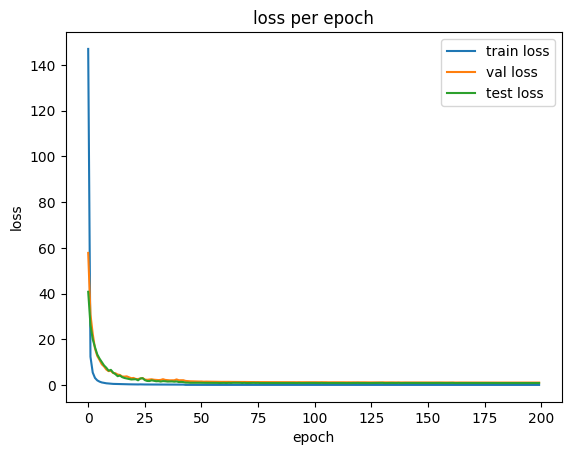

In [ ]:
plt.plot(train_losses[: ], label='train loss')
plt.plot(val_losses[:], label='val loss')
plt.plot(test_losses[:], label='test loss')
plt.legend()
plt.title("loss per epoch")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [ ]:
L_v_tar, L_v_pred = L_Pred(Test_List, 0, model, tot_denormalize_transform, input_frames, predicted_frames, segment_len, device)

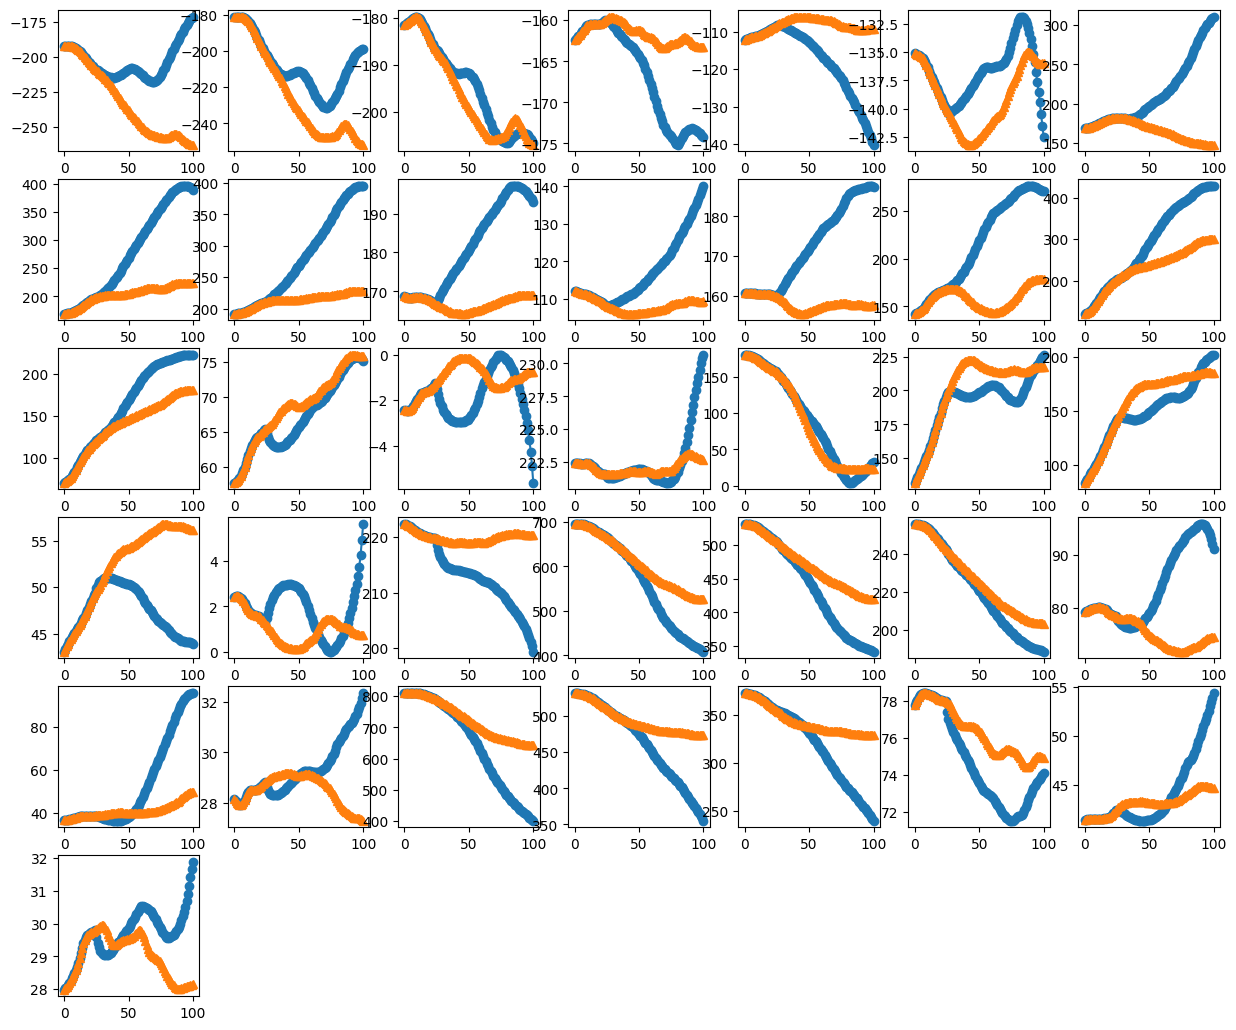

In [ ]:
plt.figure(figsize=(15, 15))
for i in range(L_v_tar.shape[2]):
  plt.subplot(7, 7, i+1)
  plt.plot(L_v_pred.squeeze().detach().cpu()[:, i], '-o', label='forecast prediction')
  plt.plot(L_v_tar.squeeze().detach().cpu()[:, i],'-^', label='forecast target' )
plt.savefig("output.png")

In [ ]:
tot_loss = 0
for i in range(len(Test_List)):
  L_v_tar, L_v_pred = L_Pred(Test_List, i, model, tot_denormalize_transform, input_frames, predicted_frames, segment_len, device)
  tot_loss = tot_loss + torch.sum(torch.sum((L_v_tar - L_v_pred)** 2))

tot_loss = torch.sqrt(tot_loss / (len(Test_List)*(101-input_frames)*segment_len))
tot_loss



tensor(33.9011, device='cuda:0')

# Best MSE


In [17]:
# Load best val model
model = TransformerBased(43, d_model=96, num_head=16, num_feed_forward=512, drop_trans=0.25, enc_num_layers=1, dec_num_layers=3, drop_fc=0, out_neurons=64)


model.to(device)
model.load_state_dict(torch.load(os.path.join(path_to_folder, "best_val_model_params.pt"), map_location=torch.device('cpu')))
model.eval()

C:\Users\Remote\AppData\Local\Temp\ipykernel_21212\1356192747.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(path_to_folde

TransformerBased(
  (dim_expander): Linear(in_features=43, out_features=96, bias=True)
  (p_enc): Summer(
    (penc): PositionalEncoding1D()
  )
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=96, out_features=96, bias=True)
        )
        (linear1): Linear(in_features=96, out_features=512, bias=True)
        (dropout): Dropout(p=0.25, inplace=False)
        (linear2): Linear(in_features=512, out_features=96, bias=True)
        (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.25, inplace=False)
        (dropout2): Dropout(p=0.25, inplace=False)
      )
    )
  )
  (decoder): TransformerDecoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerDecoderLayer(
        (self_attn): MultiheadAttention(
          (out_pr

In [18]:
i = 0
L_tar = torch.zeros(101*len(Test_List), segment_len)
L_pred = torch.zeros(101*len(Test_List), segment_len)
for j in range(len(Test_List)):
    L_v_tar, L_v_pred = L_Pred(Test_List, j, model, tot_denormalize_transform, input_frames, predicted_frames, segment_len, device)
    L_tar[0+i:101+i, :] = L_v_tar
    L_pred[0+i:101+i, :] = L_v_pred
    i = i + 101

In [19]:
RMSE_loss = RMSE_compute(L_tar, L_pred, Test_List, input_frames, segment_len, device)
nRMSE_loss = nRMSE_compute(L_tar, L_pred, my_range, Test_List, input_frames, segment_len, device)
r2_m = r2_compute(L_tar, L_pred)
print(f'RMSE: {RMSE_loss}, nRMSE: {nRMSE_loss}, r2: {r2_m}')

RMSE: 28.795886993408203, nRMSE: 0.0751500886419467, r2: 0.9870876965385444


## Segment Calculation

In [20]:
class SegmentLengthProcessor:
    def __init__(self, L_selected, Label):
        """
        Initialize with the selected data.
        L_selected: The input data for segment lengths.
        """
        self.L_selected = L_selected
        self.Label = Label
        self.arm_len = None
    
    def compute_segment_length(self):
        """
        Compute the segment length based on the selected segment indexes.
        seg_indexes: List of segment indexes to calculate the segment length.
        Returns the computed segment lengths.
        """

        label_dict = {
            'Right Shank': [7, 9, 19, 21, 31, 33], 
            'Left Shank': [1, 3, 13, 15, 25, 27],
        }

        seg_indexes = label_dict[self.Label]

        
        L_t = pd.DataFrame(self.L_selected.numpy())  # Assuming L_selected is a tensor
        arm = L_t.iloc[:, seg_indexes].copy()
        
        # Compute differences along each axis
        dx = arm[seg_indexes[0]] - arm[seg_indexes[1]]
        dy = arm[seg_indexes[2]] - arm[seg_indexes[3]]
        dz = arm[seg_indexes[4]] - arm[seg_indexes[5]]
        
        # Add difference columns
        arm['dx'] = dx
        arm['dy'] = dy
        arm['dz'] = dz
        
        # Drop the original segment columns and compute the length
        arm = arm.drop(columns=seg_indexes)
        self.arm_len = np.sqrt((arm**2).sum(axis=1))  # Calculate the segment length
        return self.arm_len
    
    def save_segment_length_to_file(self, path_to_save_folder, file_name):
        """
        Save the computed segment lengths to a CSV file.
        path_to_save_folder: The folder where the CSV file will be saved.
        label: The label to be used in the saved filename.
        """
        if self.arm_len is None:
            raise ValueError("Segment length has not been computed yet. Call compute_segment_length first.")
        
        # Save the segment lengths to a CSV file
        self.arm_len.to_csv(os.path.join(path_to_save_folder, f"{file_name}.csv"))



### Two test subjects

In [21]:
two_sub_true_dict = {'Right Shank': 'right_shank_two_sub_true', 'Left Shank': 'left_shank_two_sub_true'}

In [22]:
selected_df = L_tar
selected_dict = two_sub_true_dict
for key, value in selected_dict.items():
    processor = SegmentLengthProcessor(selected_df, key)
    seg_len = processor.compute_segment_length()
    processor.save_segment_length_to_file(path_to_outputs, value)

In [23]:
two_sub_pred_dict = {'Right Shank': 'right_shank_two_sub_pred', 'Left Shank': 'left_shank_two_sub_pred'}

In [24]:
selected_df = L_pred
selected_dict = two_sub_pred_dict
for key, value in selected_dict.items():
    processor = SegmentLengthProcessor(selected_df, key)
    seg_len = processor.compute_segment_length()
    processor.save_segment_length_to_file(path_to_outputs, value)

### One test subject: test subject 1

In [25]:
i = 0
L_tar_test_sub_1 = torch.zeros(101*len(Test_1_List), segment_len)
L_pred_test_sub_1 = torch.zeros(101*len(Test_1_List), segment_len)
for j in range(len(Test_1_List)):
    L_v_tar, L_v_pred = L_Pred(Test_1_List, j, model, tot_denormalize_transform, input_frames, predicted_frames, segment_len, device)
    L_tar_test_sub_1[0+i:101+i, :] = L_v_tar
    L_pred_test_sub_1[0+i:101+i, :] = L_v_pred
    i = i + 101

In [26]:
RMSE_loss = RMSE_compute(L_tar_test_sub_1, L_pred_test_sub_1, Test_1_List, input_frames, segment_len, device)
nRMSE_loss = nRMSE_compute(L_tar_test_sub_1, L_pred_test_sub_1, my_range, Test_1_List, input_frames, segment_len, device)
r2_m = r2_compute(L_tar_test_sub_1, L_pred_test_sub_1)
print(f'RMSE: {RMSE_loss}, nRMSE: {nRMSE_loss}, r2: {r2_m}')

RMSE: 31.09780502319336, nRMSE: 0.08569484156655172, r2: 0.9851431571446255


In [27]:
sub_1_true_dict = {'Right Shank': 'right_shank_sub_1_true', 'Left Shank': 'left_shank_sub_1_true'}

In [28]:
selected_df = L_tar_test_sub_1
selected_dict = sub_1_true_dict
for key, value in selected_dict.items():
    processor = SegmentLengthProcessor(selected_df, key)
    seg_len = processor.compute_segment_length()
    processor.save_segment_length_to_file(path_to_outputs, value)

In [29]:
sub_1_pred_dict = {'Right Shank': 'right_shank_sub_1_pred', 'Left Shank': 'left_shank_sub_1_pred'}

In [30]:
selected_df = L_pred_test_sub_1
selected_dict = sub_1_pred_dict
for key, value in selected_dict.items():
    processor = SegmentLengthProcessor(selected_df, key)
    seg_len = processor.compute_segment_length()
    processor.save_segment_length_to_file(path_to_outputs, value)

### One test subject: test subject 2

In [31]:
i = 0
L_tar_test_sub_2 = torch.zeros(101*len(Test_2_List), segment_len)
L_pred_test_sub_2 = torch.zeros(101*len(Test_2_List), segment_len)
for j in range(len(Test_2_List)):
    L_v_tar, L_v_pred = L_Pred(Test_2_List, j, model, tot_denormalize_transform, input_frames, predicted_frames, segment_len, device)
    L_tar_test_sub_2[0+i:101+i, :] = L_v_tar
    L_pred_test_sub_2[0+i:101+i, :] = L_v_pred
    i = i + 101

In [32]:
RMSE_loss = RMSE_compute(L_tar_test_sub_2, L_pred_test_sub_2, Test_2_List, input_frames, segment_len, device)
nRMSE_loss = nRMSE_compute(L_tar_test_sub_2, L_pred_test_sub_2, my_range, Test_2_List, input_frames, segment_len, device)
r2_m = r2_compute(L_tar_test_sub_2, L_pred_test_sub_2)
print(f'RMSE: {RMSE_loss}, nRMSE: {nRMSE_loss}, r2: {r2_m}')

RMSE: 26.254047393798828, nRMSE: 0.06265900810208211, r2: 0.9891158174125514


In [33]:
sub_2_true_dict = {'Right Shank': 'right_shank_sub_2_true', 'Left Shank': 'left_shank_sub_2_true'}

In [34]:
selected_df =  L_tar_test_sub_2
selected_dict = sub_2_true_dict
for key, value in selected_dict.items():
    processor = SegmentLengthProcessor(selected_df, key)
    seg_len = processor.compute_segment_length()
    processor.save_segment_length_to_file(path_to_outputs, value)

In [36]:
sub_2_pred_dict = {'Right Shank': 'right_shank_sub_2_pred', 'Left Shank': 'left_shank_sub_2_pred'}

In [37]:
selected_df = L_pred_test_sub_2
selected_dict = sub_2_pred_dict
for key, value in selected_dict.items():
    processor = SegmentLengthProcessor(selected_df, key)
    seg_len = processor.compute_segment_length()
    processor.save_segment_length_to_file(path_to_outputs, value)

In [40]:
L_v_tar, L_v_pred = L_Pred(Test_List, 2, model, tot_denormalize_transform, input_frames, predicted_frames, segment_len, device)

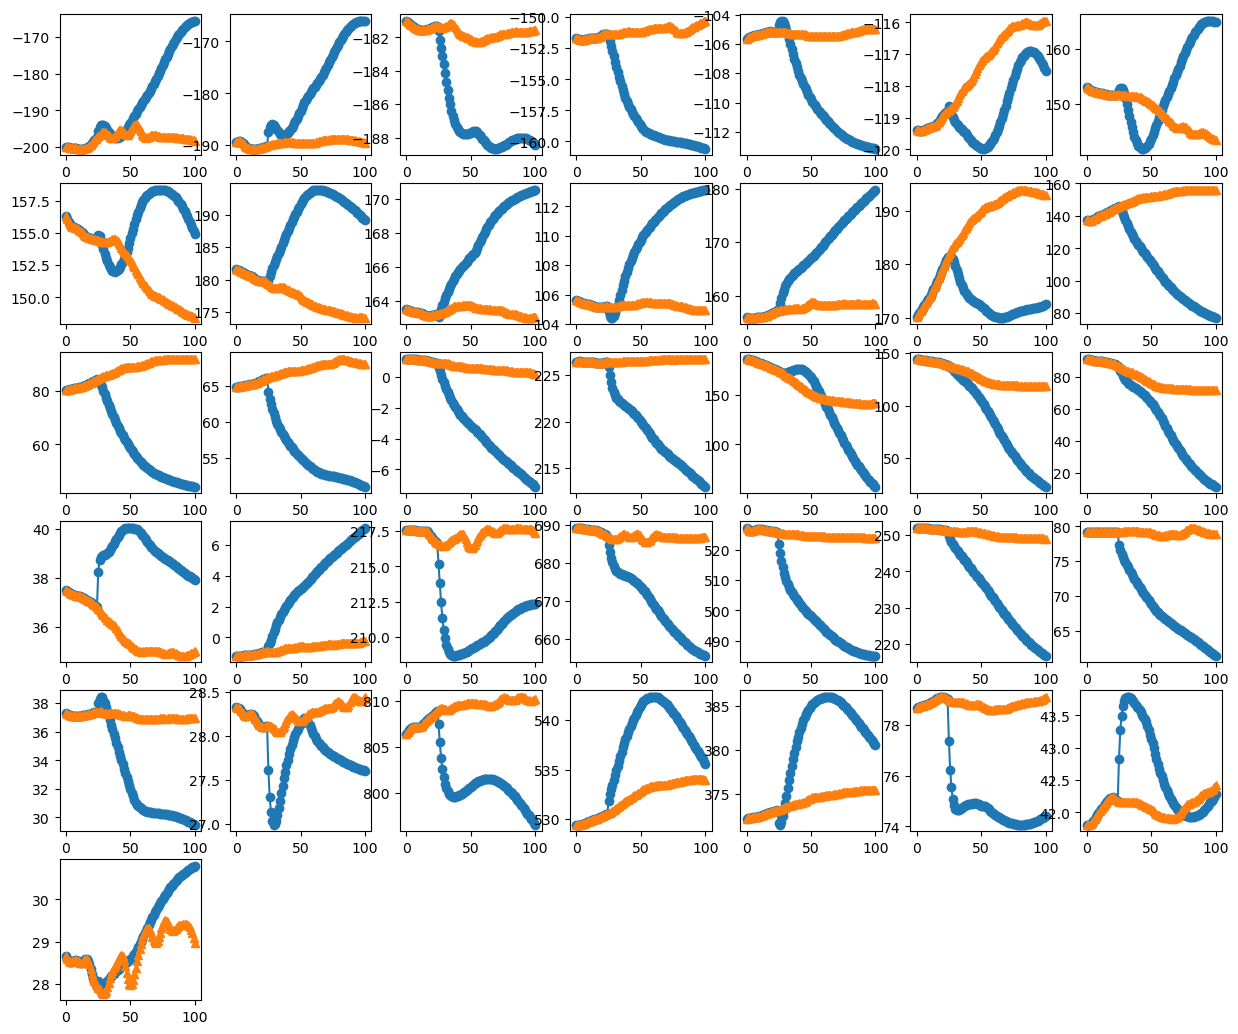

In [41]:
plt.figure(figsize=(15, 15))
for i in range(L_v_tar.shape[2]):
  plt.subplot(7, 7, i+1)
  plt.plot(L_v_pred.squeeze().detach().cpu()[:, i], '-o', label='forecast prediction')
  plt.plot(L_v_tar.squeeze().detach().cpu()[:, i],'-^', label='forecast target' )


In [42]:
pred_c = pd.DataFrame(L_v_pred.detach().cpu().squeeze())
pred_c
pred_c.to_csv('Leg_T_pred.csv')

In [43]:
tar_c = pd.DataFrame(L_v_tar.detach().cpu().squeeze())
tar_c
tar_c.to_csv('Leg_T_tar.csv')